In [ ]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Apply, String Methods

In this section, we will answer the question:

**Can we use the last letter of a name to predict the sex of the baby?**

Here's the Baby Names dataset once again:

In [3]:
baby = pd.read_csv('babynames.csv')
baby.head()
# the .head() method outputs the first five rows of the DataFrame

,Name,Sex,Count,Year
0,Mary,F,9217,1884
1,Anna,F,3860,1884
2,Emma,F,2587,1884
3,Elizabeth,F,2549,1884
4,Minnie,F,2243,1884


**Breaking the Problem Down**

Although there are many ways to see whether prediction is possible, we will use plotting in this section. We can decompose this question into two steps:

1. Compute the last letter of each name.
1. Group by the last letter and sex, aggregating on Count.
1. Plot the counts for each sex and letter.

## Apply

`pandas` Series contain an `.apply()` method that takes in a function and applies it to each value in the Series.

In [7]:
names = baby['Name']
names.apply(len)

0          4
1          4
2          4
          ..
1891891    5
1891892    6
1891893    8
Name: Name, Length: 1891894, dtype: int64

To extract the last letter of each name, we can define our own function to pass into `.apply()`:

In [8]:
def last_letter(string):
    return string[-1]

names.apply(last_letter)

0          y
1          a
2          a
          ..
1891891    a
1891892    e
1891893    p
Name: Name, Length: 1891894, dtype: object

## String Manipulation

Although `.apply()` is flexible, it is often faster to use the built-in string manipulation functions in `pandas` when dealing with text data.

`pandas` provides access to string manipulation functions using the `.str` attribute of Series.

In [9]:
names = baby['Name']
names.str.len()

0          4
1          4
2          4
          ..
1891891    5
1891892    6
1891893    8
Name: Name, Length: 1891894, dtype: int64

We can directly slice out the last letter of each name in a similar way.

In [10]:
names.str[-1]

0          y
1          a
2          a
          ..
1891891    a
1891892    e
1891893    p
Name: Name, Length: 1891894, dtype: object

We suggest looking at the docs for the full list of string methods ([link](https://pandas.pydata.org/pandas-docs/stable/text.html)).

We can now add this column of last letters to our `baby` DataFrame.

In [11]:
baby['Last'] = names.str[-1]
baby

,Name,Sex,Count,Year,Last
0,Mary,F,9217,1884,y
1,Anna,F,3860,1884,a
2,Emma,F,2587,1884,a
...,...,...,...,...,...
1891891,Verna,M,5,1883,a
1891892,Winnie,M,5,1883,e
1891893,Winthrop,M,5,1883,p


## Grouping

To compute the sex distribution for each last letter, we need to group by both Last and Sex.

In [13]:
# Shorthand for baby.groupby(['Last', 'Sex']).agg(np.sum)
baby.groupby(['Last', 'Sex']).sum()

Count       Year
Last Sex                     
a    F    58079486  915565667
     M     1931630   53566324
b    F       17376    1092953
...            ...        ...
y    M    18569388  114394474
z    F      142023    4268028
     M      120123    9649274

[52 rows x 2 columns]

Notice that `Year` is also summed up since each non-grouped column is passed into the aggregation function. To avoid this, we can select out the desired columns before calling `.groupby()`.

In [15]:
# When lines get long, you can wrap the entire expression in parentheses
# and insert newlines before each method call
letter_dist = (
    baby[['Last', 'Sex', 'Count']]
    .groupby(['Last', 'Sex'])
    .sum()
)
letter_dist

Count
Last Sex          
a    F    58079486
     M     1931630
b    F       17376
...            ...
y    M    18569388
z    F      142023
     M      120123

[52 rows x 1 columns]

## Plotting

`pandas` provides built-in plotting functionality for most basic plots, including bar charts, histograms, line charts, and scatterplots. To make a plot from a DataFrame, use the `.plot` attribute:

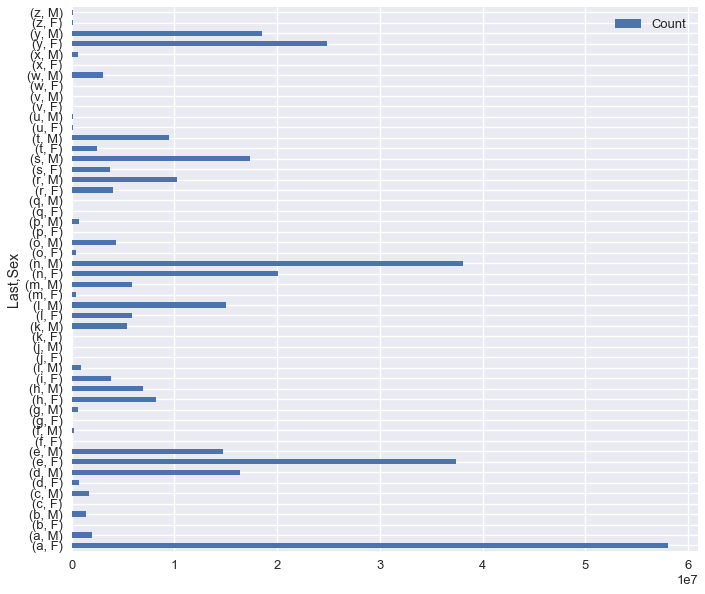

In [26]:
# We use the figsize option to make the plot larger
letter_dist.plot.barh(figsize=(10, 10))

Although this plot shows the distribution of letters and sexes, the male and female bars are difficult to tell apart. By looking at the `pandas` docs on plotting ([link](https://pandas.pydata.org/pandas-docs/stable/visualization.html)) we learn that `pandas` plots one group of bars for row column in the DataFrame, showing one differently colored bar for each column. This means that a pivoted version of the `letter_dist` table will have the right format.

In [20]:
letter_pivot = pd.pivot_table(
    baby, index='Last', columns='Sex', values='Count', aggfunc='sum'
)
letter_pivot

Sex,F,M
Last,,
a,58079486,1931630
b,17376,1435939
c,30262,1672407
...,...,...
x,37381,644092
y,24877638,18569388
z,142023,120123


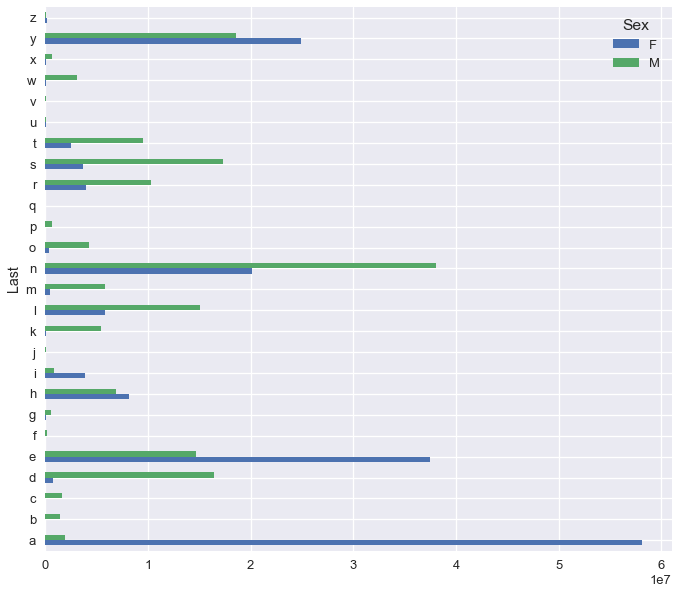

In [27]:
letter_pivot.plot.barh(figsize=(10, 10))

Notice that `pandas` conveniently generates a legend for us as well. However, this is still difficult to interpret. We plot the counts for each letter and sex which causes some bars to appear very long and others to be almost invisible. We should instead plot the proportion of male and female babies within each last letter.

In [32]:
total_for_each_letter = letter_pivot['F'] + letter_pivot['M']

letter_pivot['F prop'] = letter_pivot['F'] / total_for_each_letter
letter_pivot['M prop'] = letter_pivot['M'] / total_for_each_letter
letter_pivot

Sex,F,M,F prop,M prop
Last,,,,
a,58079486,1931630,0.967812,0.032188
b,17376,1435939,0.011956,0.988044
c,30262,1672407,0.017773,0.982227
...,...,...,...,...
x,37381,644092,0.054853,0.945147
y,24877638,18569388,0.572597,0.427403
z,142023,120123,0.541771,0.458229


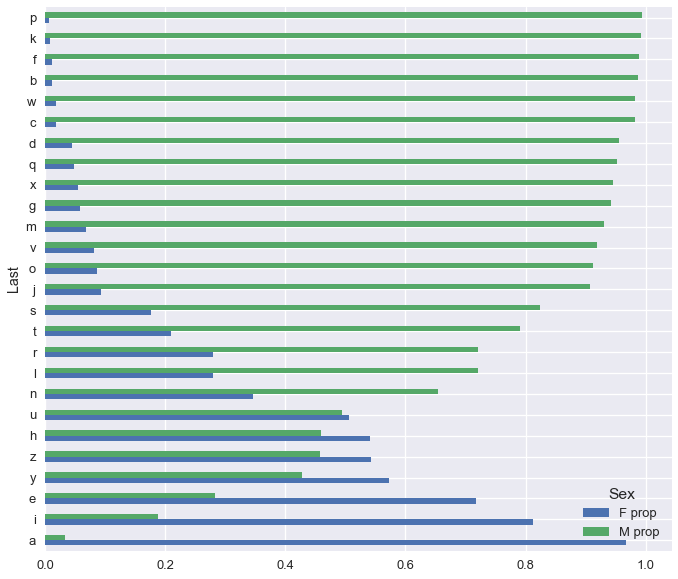

In [34]:
(letter_pivot[['F prop', 'M prop']]
 .sort_values('M prop') # Sorting orders the plotted bars
 .plot.barh(figsize=(10, 10))
)

## Summary

We can see that almost all first names that end in 'p' are male and names that end in 'a' are female! In general, the difference between bar lengths for many letters implies that we can often make a good guess to a person's sex if we just know the last letter of their first name.

We've learned to express the following operations in `pandas`:

| Operation | `pandas` |
| --------- | -------  |
| Applying a function elementwise | `series.apply(func)` |
| String manipulation | `series.str.func()` |
| Plotting | `df.plot.func()` |